In [1]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [2]:
print tf.__version__

1.2.1


In [3]:
learning_rate = 0.001
batch_size = 100
disp_freq = 100

n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75

x = tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [4]:

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
# Create model
def conv_net(x, weights, biases):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

class Model:


    def __init__(self, x, y_):

        self.x = x # input placeholder
    
        weights = {
        # 5x5 conv, 1 input, 32 outputs
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 32],stddev=0.001)),
        # 5x5 conv, 32 inputs, 64 outputs
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 32, 64],stddev=0.001)),
        # fully connected, 7*7*64 inputs, 1024 outputs
        'wd1': tf.Variable(tf.truncated_normal([7*7*64, 1024],stddev=0.001)),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.truncated_normal([1024, n_classes],stddev=0.001))
        }

        biases = {
        'bc1': tf.Variable(tf.truncated_normal([32],stddev=0.001)),
        'bc2': tf.Variable(tf.truncated_normal([64],stddev=0.001)),
        'bd1': tf.Variable(tf.truncated_normal([1024],stddev=0.001)),
        'out': tf.Variable(tf.truncated_normal([n_classes],stddev=0.001))
        }
       
        
        self.y = conv_net(x, weights, biases)

        self.var_list=[weights['wc1'],weights['wc2'],weights['wd1'],weights['out'],
                       biases['bc1'],biases['bc2'],biases['bd1'],biases['out']]

        # simple 2-layer network
#         in_dim = int(x.get_shape()[1]) # 784 for MNIST
#         out_dim = int(y_.get_shape()[1]) # 10 for MNIST

#         W1 = weight_variable([in_dim,50])
#         b1 = bias_variable([50])

#         W2 = weight_variable([50,out_dim])
#         b2 = bias_variable([out_dim])

#         h1 = tf.nn.relu(tf.matmul(x,W1) + b1) # hidden layer    
#         self.y = tf.matmul(h1,W2) + b2
#         self.var_list = [W1, b1, W2, b2]
        
        
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y,labels=y_))

        self.set_vanilla_loss()
        
        
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        

    def compute_fisher(self, imgset, sess, num_samples=200, plot_diffs=False, disp_freq=10):
        # compute Fisher information for each parameter

        # initialize Fisher information for most recent task
        self.F_accum = []
        for v in range(len(self.var_list)):
            self.F_accum.append(np.zeros(self.var_list[v].get_shape().as_list()))

        # sampling a random class from softmax
        probs = tf.nn.softmax(self.y)
        class_ind = tf.to_int32(tf.multinomial(tf.log(probs), 1)[0][0])

        if(plot_diffs):
            # track differences in mean Fisher info
            F_prev = deepcopy(self.F_accum)
            mean_diffs = np.zeros(0)

        for i in range(num_samples):
            # select random input image
            im_ind = np.random.randint(imgset.shape[0])
            # compute first-order derivatives
            ders = sess.run(tf.gradients(tf.log(probs[0,class_ind]), self.var_list), feed_dict={self.x: imgset[im_ind:im_ind+1]})
            # square the derivatives and add to total
            for v in range(len(self.F_accum)):
                self.F_accum[v] += np.square(ders[v])
            if(plot_diffs):
                if i % disp_freq == 0 and i > 0:
                    # recording mean diffs of F
                    F_diff = 0
                    for v in range(len(self.F_accum)):
                        F_diff += np.sum(np.absolute(self.F_accum[v]/(i+1) - F_prev[v]))
                    mean_diff = np.mean(F_diff)
                    mean_diffs = np.append(mean_diffs, mean_diff)
                    for v in range(len(self.F_accum)):
                        F_prev[v] = self.F_accum[v]/(i+1)
                    plt.plot(range(disp_freq+1, i+2, disp_freq), mean_diffs)
                    plt.xlabel("Number of samples")
                    plt.ylabel("Mean absolute Fisher difference")
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

        # divide totals by number of samples
        for v in range(len(self.F_accum)):
            self.F_accum[v] /= num_samples
    
    def set_vanilla_loss(self):
        self.train_step = tf.train.AdamOptimizer(0.01).minimize(self.cross_entropy)

    def star(self):
    # used for saving optimal weights after most recent task training
        self.star_vars = []
        for v in range(len(self.var_list)):
            self.star_vars.append(self.var_list[v].eval())
    def update_ewc_loss(self, lam):
        # elastic weight consolidation
        # lam is weighting for previous task(s) constraints

        if not hasattr(self, "ewc_loss"):
            self.ewc_loss = self.cross_entropy

        for v in range(len(self.var_list)):
            self.ewc_loss += (lam/2) * tf.reduce_sum(tf.multiply(self.F_accum[v].astype(np.float32),tf.square(self.var_list[v] - self.star_vars[v])))
        self.train_step = tf.train.AdamOptimizer(0.01).minimize(self.ewc_loss)
    def restore(self, sess):
    # reassign optimal weights for latest task
        if hasattr(self, "star_vars"):
            for v in range(len(self.var_list)):
                sess.run(self.var_list[v].assign(self.star_vars[v]))

In [5]:

model = Model(x, y_)
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
from tensorflow.python.framework import dtypes

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
i = 0
train_img = mnist.train.images
mnist1_img = []
mnist1_label = []
mnist2_img = []
mnist2_label = []
mnist3_img = []
mnist3_label = []

mnist1_test_img = []
mnist1_test_label = []
mnist2_test_img = []
mnist2_test_label = []
mnist3_test_img = []
mnist3_test_label = []

test_img = mnist.test.images

while(i < train_img.shape[0]):
    batch = mnist.train.next_batch(1)
    if (np.where(batch[1] == 1)[1] <= 3):
        mnist1_img.append(batch[0])
        mnist1_label.append(batch[1])
    if (np.where(batch[1] == 1)[1] > 3 and np.where(batch[1] == 1)[1] <= 6):
        mnist2_img.append(batch[0])
        mnist2_label.append(batch[1])
    if (np.where(batch[1] == 1)[1] > 6):
        mnist3_img.append(batch[0])
        mnist3_label.append(batch[1])
    i+=1
    


#print mnist1
j = 0
while(j < test_img.shape[0]):
    batch = mnist.test.next_batch(1)
    if (np.where(batch[1] == 1)[1] <= 3):
        mnist1_test_img.append(batch[0])
        mnist1_test_label.append(batch[1])
    if (np.where(batch[1] == 1)[1] > 3 and np.where(batch[1] == 1)[1] <= 6):
        mnist2_test_img.append(batch[0])
        mnist2_test_label.append(batch[1])
    if (np.where(batch[1] == 1)[1] > 6):
        mnist3_test_img.append(batch[0])
        mnist3_test_label.append(batch[1])
    j+=1
    

    
reshape = True
dtype=dtypes.float32

options = dict(dtype=dtype,reshape=reshape,seed = None)

def mnistreshape(inputdata):
    inputdata = np.array(inputdata)
    return inputdata.reshape(inputdata.shape[0],28,28,1)

mnist1_img = mnistreshape(mnist1_img)
mnist2_img = mnistreshape(mnist2_img)
mnist3_img = mnistreshape(mnist3_img)
mnist1_test_img = mnistreshape(mnist1_test_img)
mnist2_test_img = mnistreshape(mnist2_test_img)
mnist3_test_img = mnistreshape(mnist3_test_img)

mnist1_label = np.array(mnist1_label)
mnist2_label = np.array(mnist2_label)
mnist3_label = np.array(mnist3_label)
mnist1_test_label = np.array(mnist1_test_label)
mnist2_test_label = np.array(mnist2_test_label)
mnist3_test_label = np.array(mnist3_test_label)

mnist1 = DataSet(mnist1_img,mnist1_label,**options)
mnist2 = DataSet(mnist2_img,mnist2_label,**options)
mnist3 = DataSet(mnist3_img,mnist3_label,**options)
mnist1_t = DataSet(mnist1_test_img,mnist1_test_label,**options)
mnist2_t = DataSet(mnist2_test_img,mnist2_test_label,**options)
mnist3_t = DataSet(mnist3_test_img,mnist3_test_label,**options)

In [6]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

def permute_mnist(mnist):
    perm_inds = range(mnist.train.images.shape[1])
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)


In [7]:
def train_task(model, num_iter, disp_freq,sess, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        temp = set(tf.global_variables())
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
            #model.train_step = tf.train.AdamOptimizer(0.01).minimize(model.ewc_loss)
        # initialize test accuracy array for each task 
        #Optimizer = tf.train.AdamOptimizer(0.01).minimize(model.ewc_loss)
        sess.run(tf.variables_initializer(set(tf.global_variables()) - temp))
        
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
        # train on current task
        step = 0
        for iter in range(num_iter):
            batch = trainset.train.next_batch(batch_size)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            #print model.prediction.eval(feed_dict={x: mnist.test.images})
            if (iter % disp_freq == 0):
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("Cross Entropy")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [8]:
def train_task_separate(model, num_iter, disp_freq,sess, trainset,setnum, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        temp = set(tf.global_variables())
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
            #model.train_step = tf.train.AdamOptimizer(0.01).minimize(model.ewc_loss)
        # initialize test accuracy array for each task 
        #Optimizer = tf.train.AdamOptimizer(0.01).minimize(model.ewc_loss)
        sess.run(tf.variables_initializer(set(tf.global_variables()) - temp))
        
        test_accs = []

        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
        # train on current task
        step = 0
        for iter in range(num_iter):
            img = []
            label = []
            batch = trainset.train.next_batch(batch_size)
            #print batch[1]
            #print len(batch[1])
            for i in range(len(batch[1])):
                if(setnum == 1):
                    #print np.where(batch[1][i] == 1)[0][0]
                    if(np.where(batch[1][i] == 1)[0][0] <= 3):
                        #print "here"
                        img.append(batch[0][i])
                        label.append(batch[1][i])
                if(setnum == 2):
                    if(np.where(batch[1][i] == 1)[0][0] > 3 and np.where(batch[1][i] == 1)[0][0] <= 6):
                        img.append(batch[0][i])
                        label.append(batch[1][i])
                if(setnum == 3):
                    if(np.where(batch[1][i] == 1)[0][0] > 6 ):
                        img.append(batch[0][i])
                        label.append(batch[1][i])
            #print label
            #break
            model.train_step.run(feed_dict={x: img, y_: label})
            #print model.prediction.eval(feed_dict={x: mnist.test.images})
            if (iter % disp_freq == 0):
                plt.subplot(1, len(lams), l+1)
                plots = []
                testimg = []
                testlabel = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
#                     for i in range(batch_size):
#                         #print testsets[task].test.images.shape[0]
#                         if(task == 0):
#                             if(np.where(testsets[task].test.labels[i] == 1)[0][0] <= 3):
#                                 testimg.append(testsets[task].test.images[i])
#                                 testlabel.append(testsets[task].test.labels[i])
#                         if(task == 1):
#                             #print "setnum2"
#                             #if(np.where(testsets[task].test.labels[i] == 1)[0][0] > 3 and np.where(testsets[task].test.labels[i] == 1)[0][0] <= 6):
#                             if(np.where(testsets[task].test.labels[i] == 1)[0][0] <= 6):
#                                 testimg.append(testsets[task].test.images[i])
#                                 testlabel.append(testsets[task].test.labels[i])
#                         if(task == 2):
#                             #print "setnum3"
#                             #if(np.where(testsets[task].test.labels[i] == 1)[0][0] > 6):
#                             if(np.where(testsets[task].test.labels[i] == 1)[0][0] <= 9):
#                                 testimg.append(testsets[task].test.images[i])
#                                 testlabel.append(testsets[task].test.labels[i])   
#                     #print testlabel
#                     feed_dict={x: testimg, y_: testlabel}
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("Cross Entropy")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

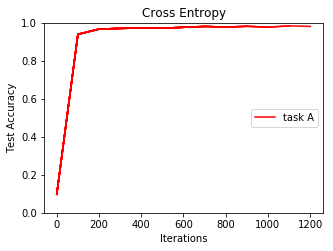

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_task(model, 1300, 100, sess, mnist, [mnist], x, y_, lams=[0])
#train_task_separate(model, 1300, 100, sess, mnist,1, [mnist], x, y_, lams=[0])

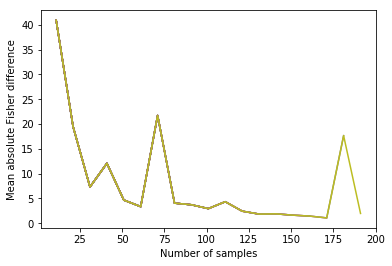

In [10]:
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True)

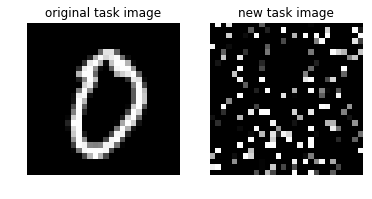

In [12]:
mnist2 = permute_mnist(mnist)

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[5])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[5])
plt.title("new task image");

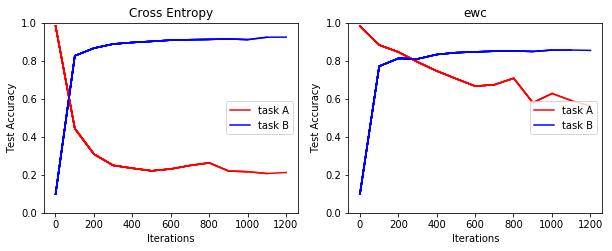

In [13]:

model.star()
train_task(model, 1300, 100,sess, mnist2, [mnist, mnist2], x, y_, lams=[0, 500])
#train_task_separate(model, 1300, 100,sess, mnist,2, [mnist, mnist], x, y_, lams=[0, 15])